<a href="https://colab.research.google.com/github/Astra42/ImageComparison/blob/main/OverLiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Генератор пар изображений по заданным параметрам

загрузка исходников



In [1]:
import cv2
import numpy as np
import random as rm
from google.colab.patches import cv2_imshow
import string
import math
import os.path

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!mkdir data
!mkdir forms
!mkdir TemplatesJPG
!cp -r /content/gdrive/'My Drive'/ImageComparison/TemplatesJPG/* /content/TemplatesJPG
!cp -r /content/gdrive/'My Drive'/ImageComparison/forms/* /content/forms
!cp -r /content/gdrive/'My Drive'/ImageComparison/data/* /content/data

Mounted at /content/gdrive


вспомогательные классы

In [108]:
class Point:
  def __init__(self, x,y):
    self.x, self.y = x, y
  def addForEach(self, x, y):
    self.x+=x
    self.y+=y

  def get(self):
    return self.x, self.y
  
  def __str__(self):
      return f"x{self.x} y{self.y}"

In [151]:
class MainFrame:
  def __init__(self, corners, shift=10):
    #shift - небольшой сдвиг чтобы чертеж не накладывался на шаблон
    self.corners = corners
    self.shape = (np.abs(corners[3].x - corners[1].x)-shift, np.abs(corners[3].y - corners[1].y)-shift)#width height
    armin = [corner.x+corner.y for corner in self.corners]
    self.leftcorner = self.corners[armin.index(min(armin))]
    self.leftcorner.addForEach(shift//2, shift//2)
  
  def __str__(self):
      return [str(c) for c in self.corners]

варианты бордер файндера

In [5]:
def findBorder(img):
  midy,midx = img.shape[0]//2, img.shape[1]//2
  points = [Point(midx, midy) for _ in range(4)]
  top=0
  
  while(img[points[0].y,points[0].x][0] > 200):
    points[0].y-=1
    top+=1

  left=0
  while(img[points[3].y,points[3].x][0] > 200):
    points[3].x-=1
    left+=1

  bottom,right=0,0
  while(img[points[1].y,points[1].x][0] > 200):
    points[1].x+=1
    right+=1

  points[2] = Point(points[1].x-5, points[1].y)
  while(img[points[2].y,points[2].x][0] > 200):
    points[2].y+=1
    bottom+=1

  corners = [Point(points[3].x, points[0].y),
             Point(points[1].x, points[0].y), 
             Point(points[1].x, points[2].y),
             Point(points[3].x, points[2].y),]
  
  mf = MainFrame(corners)

  return mf

In [6]:
def findAllBorder(img):
  midy,midx = img.shape[0]//2, img.shape[1]//2
  points = [Point(midx, midy) for _ in range(4)]
  operations = [lambda p: Point(p.x,p.y-1), lambda p:Point(p.x+1, p.y), lambda p:Point(p.x,p.y+1), lambda p:Point(p.x-1, p.y)]#move toward t,r,d,l
  corners = [[Point(midx, midy) for _ in range(4)] for i in range(4)]#4 points for the each runner
  dists = [[0,0,0,0] for i in range(4)] # dists to t,r,d,l
  runners = [Point(midx, midy) for _ in range(4)]

  for i in range(4):#for each runners
    for j in range(4):# for four sides
      while(img[runners[i].y, runners[i].x][0] > 250):
        # print("ij",i,j, 'val', img[runners[i].y, runners[i].x][0],'coord', runners[i].x, runners[i].y)
        runners[i] = operations[(i+j)%4](runners[i])#move
      # print('##############', "ij", i,j, 'val', img[runners[i].y, runners[i].x][0],'coord', runners[i].x, runners[i].y)
      corners[i][j] = Point(runners[i].x, runners[i].y)#if we touch - will note the node
      
      opposite_oper = (i+j+2)%4 #the small opposite shift from bounds
      runners[i] = operations[opposite_oper](runners[i])
      runners[i] =operations[opposite_oper](runners[i])
      runners[i] =operations[opposite_oper](runners[i])


 
  s = [np.abs(r[3].x - r[1].x) * np.abs(r[3].y - r[1].y)  for r in corners]
  maxS = np.max(s)

  corners = corners[s.index(maxS)]
  
  mf = MainFrame(corners)
  return mf

In [99]:
def findAllBorderNew(img): 
  midy,midx = img.shape[0]//2, img.shape[1]//2
  # print(img[midy,midx][0],img[midy,midx][1],img[midy,midx][2], img[midy,midx][3])
  points = [Point(midx, midy) for _ in range(4)]
  operations = [lambda p: Point(p.x,p.y-1), lambda p:Point(p.x+1, p.y), lambda p:Point(p.x,p.y+1), lambda p:Point(p.x-1, p.y)]#move toward t,r,d,l
  corners = [[Point(midx, midy) for _ in range(4)] for i in range(4)]#4 points for the each runner
  dists = [[0,0,0,0] for i in range(4)] # dists to t,r,d,l
  runners = [Point(midx, midy) for _ in range(4)]
  #каждый ранер доведем до границы и до первой ноды - а после 4 раза по границам
  for i in range(4):#for each runners
    for j in range(6):# for four sides
      while(img[runners[i].y, runners[i].x][0] > 250):
        # print("ij",i,j, 'val', img[runners[i].y, runners[i].x][0],'coord', runners[i].x, runners[i].y)
        runners[i] = operations[(i+j)%4](runners[i])#move
      # print('##############', "ij", i,j, 'val', img[runners[i].y, runners[i].x][0],'coord', runners[i].x, runners[i].y)
      if j > 1:
        corners[i][j-2] = Point(runners[i].x, runners[i].y)#if we touch - will note the node
      opposite_oper = (i+j+2)%4 #the small opposite shift from bounds
      for _ in range(3):
        runners[i] = operations[opposite_oper](runners[i])

  s = [np.abs(r[3].x - r[1].x) * np.abs(r[3].y - r[1].y)  for r in corners]
  # print("площади:"s)
  maxS = np.max(s)

  corners = corners[s.index(maxS)]
  
  mf = MainFrame(corners)
  return mf

метод для наложения PNG изображения на бекгрануд

In [8]:
def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0
    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image
    return background

получение шаблона с разметкой 


In [9]:
temp = cv2.imread("/content/TemplatesJPG/1.jpg")
form = cv2.imread("/content/forms/f5.png", -1)


b = overlay_transparent(temp, form, 10, 10)




mf = findAllBorderNew(b)
  #logging
for i in mf.corners:
  cv2.circle(b, i.get(), 5, (255, 40, 40), cv2.FILLED)
  print("поинт по координатам", i.get())

cv2.rectangle(b, (mf.corners[3].x, mf.corners[3].y) , (mf.corners[1].x, mf.corners[1].y), (200, 100, 40))
cv2_imshow(b)






поинт по координатам (240, 6304)
поинт по координатам (243, 229)
поинт по координатам (9873, 232)
поинт по координатам (9870, 6307)


метод получения шаблона и его мейнфрема(метаданные о внутренней области)

In [103]:
def getTemplate(scale_percent=28):
  temp_dir = '/content/TemplatesJPG'  #папка шаблонов
  temp_names = os.listdir(temp_dir)
  template = cv2.imread(f"{temp_dir}/{7}.jpg")#rm.choice(temp_names)
  width = int(template.shape[1] * scale_percent / 100)
  height = int(template.shape[0] * scale_percent / 100)
  dim = (width, height)

  template = cv2.resize(template, dim)
  print(f'img shape:{template.shape}')

  mf = findAllBorderNew(template)
  #logging
  for i in mf.corners:
    cv2.circle(template, i.get(), 5, (255, 40, 40), cv2.FILLED)
    print("поинт по координатам", i.get())

  cv2.rectangle(template, (mf.corners[3].x, mf.corners[3].y) , (mf.corners[1].x, mf.corners[1].y), (200, 100, 40))
  # cv2_imshow(template)
  return template, mf


 

img shape:(982, 694, 3)
поинт по координатам (675, 833)
поинт по координатам (66, 830)
поинт по координатам (69, 17)
поинт по координатам (678, 20)


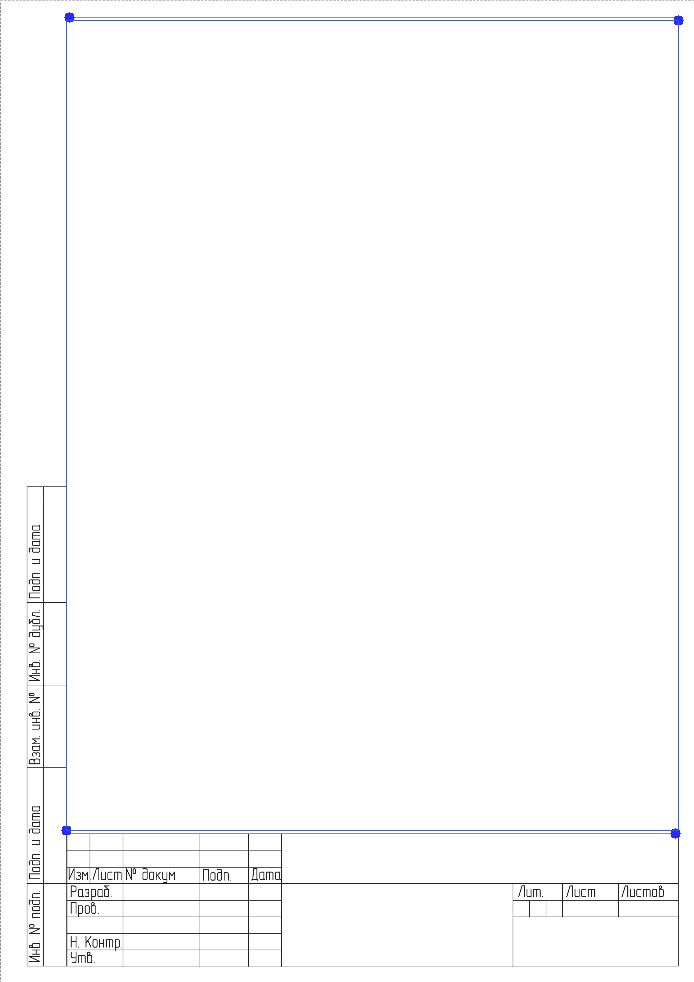

In [93]:
а = getTemplate()

Вase

In [40]:
#Base
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
class Polygon:
  def __init__(self, xy, shape):
    self.xy = xy
    self.x = xy[0]
    self.y = xy[1]
    self.shape = shape
    self.w = shape[0]
    self.h = shape[1]
    self.square = self.w*self.h


class Polygon_finder:
  def __init__(self):
    self.figures = {"r": self.find_for_rectangle, "f":self.find_for_rectangle}

  def find_for_rectangle(self, polygons,caller, min_square):
    if len(polygons)==0:
      print("Нет полигонов")
      return 0
    polygon_index = rm.choice(range(len(polygons)))
    polygon = polygons.pop(polygon_index)
    while polygon.square<min_square:
      l = len(polygons)
      if l==0:
        print("Нет полигонов с необходимым мин размером")
        return 0
      else:
        polygon_index = rm.choice(range(l))
        polygon = polygons.pop(polygon_index)
    
    return polygon

  def init_search(self, polygons, figure, min_square):
    return self.figures[figure](polygons, figure, min_square)



def random_color(a=0, b=240):
  return (rm.randint(a, b), rm.randint(a, b), rm.randint(a, b))

def random_point(img_shape):
  return (rm.randint(0,img_shape[0]), rm.randint(0,img_shape[1]))

def floor(x):
  return math.floor(x)

def ceil(x):
  return math.ceil(x)


#Saver
#----------------------------------------------------------------------------------------------------------------------------------------------------------
def save_images(images, folder_name="media"):
  f_name = f"/{folder_name}/count_of_same_sample.txt"
  if not os.path.exists(f_name):
    open(f_name, 'w').write("0")
  
  count_of_same_images = int(open(f_name, 'r').read(1))

  for i in range(len(images)):
    cv2.imwrite(f"/{folder_name}/sample{count_of_same_images}_{i}.jpg", images[i])
  
  open(f_name, 'w').write(str(count_of_same_images+1))


#Figures
#---------------------------------------------------------------------------------------------------------------------------------------------------
class Rectangle:
  def __init__(self, polygon, min_square, padding=0.05):
    #print(type(polygon), type(min_square))
    max_x =np.floor(polygon.w - min_square/polygon.h)
    x = rm.randint(0, max_x)
    max_y = np.floor(polygon.h - min_square/(polygon.w-x))
    y = rm.randint(0, max_y)
    p = (x,y)
    min_w = np.ceil(min_square/(polygon.h - y))
    w = rm.randint(min_w, polygon.w-p[0])
    min_h = np.ceil(min_square/w)
    h = rm.randint(min_h, polygon.h-p[1])
    self.shape = (w,h)
    #print(self.shape[0]*self.shape[1])
    self.start_point = (p[0]+polygon.x, p[1]+polygon.y)
    self.end_point = (self.shape[0] + self.start_point[0], self.shape[1] + self.start_point[1])

    self.outside_min_polygon = Polygon(self.start_point, self.shape)
    self.polygon_inside = Polygon((round(self.start_point[0] + self.shape[0]*padding), round(self.start_point[1] + self.shape[1]*padding)),
                                  (round(self.shape[0]*(1-2*padding)), round(self.shape[1]*(1-2*padding))))
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #self.polygon_inside нужно давать через твой поиск внутренней формы, а не так, как здесь написано
    #структура - Polygon(верхняя левая точка х, верхняя левая точка y, (ширина, высота))
    

def draw_rectangle(img, polygon, min_square, putting_img):
  #здесь последний уровень вложенности, где можно обратиться к putting_img и найти ее внутренности
  
  r = Rectangle(polygon, min_square)
  #можешь изменить polygon_inside так: r.polygon_inside= ...
  x,y = r.start_point
  w,h = r.shape
  print(r.shape, putting_img.shape)
  

  resized_img = cv2.resize(putting_img, (w,h))  #изображение ресаизится под полигон, мб, надо сделать эту штуку чуть пограмотнее
  
  print(r.shape, resized_img.shape, w, h)
  
  resized_img = cv2.resize(putting_img, (h,w))
  cv2_imshow()
  img = overlay_transparent(img, resized_img, y, x)
  # img[x:x+w, y:y+h,:]=resized_img
  

  print("log resized_img.shape and .img.shape", resized_img.shape,img.shape, y+h, x+w)
  return r

#Methods and Class Union
#-----------------------------------------------------------------------------------------------------------------------------------
class Plot:
  def __init__(self, img):
    self.img = img
    self.possible_polygons = [Polygon((0,0), img.shape[:2])]
    self.figures_in_plot = []
    self.possible_figures_draw_methods = {"r": draw_rectangle}
    self.possible_polygons_inside_forms = []

  def draw_figure(self, figure_name, min_figure_square, input_img):
    finder = Polygon_finder()
    used_pol = self.possible_polygons if figure_name=="f" else self.possible_polygons_inside_forms
    polygon = finder.init_search(used_pol, figure_name, min_figure_square)

    if type(polygon)==type(1):
      return False

    #print(polygon.square)
    figure = self.possible_figures_draw_methods["r"](self.img, polygon, min_figure_square, input_img)
    self.figures_in_plot.append(figure)

    outside = figure.outside_min_polygon
    #print(outside.xy, outside.shape)
    first_p = Polygon((polygon.x, polygon.y), (outside.x-polygon.x + outside.w, outside.y-polygon.y))
    second_p = Polygon((polygon.x + first_p.w, polygon.y), (polygon.w-first_p.w, outside.y-polygon.y+outside.h))
    third_p = Polygon((outside.x, outside.y+outside.h), (polygon.w-outside.x+polygon.x, polygon.h-second_p.h))
    fourth_p = Polygon((polygon.x, polygon.y+first_p.h), (polygon.w-third_p.w, polygon.h-first_p.h))
    inside_p = figure.polygon_inside
    if figure_name=="f":
      self.possible_polygons_inside_forms.append(inside_p)

    new_polygons = [first_p, second_p, third_p, fourth_p]
    #new_polygons = filter(lambda x: x.square>=min_figure_square, new_polygons)
    for p in new_polygons:
      if figure_name=="f":
        self.possible_polygons.append(p)
      else:
        self.possible_polygons_inside_forms.append(p)

    return True

In [172]:
def make_random_images(img_shape, count, percent, form_count=4, dict_of_k={"r":0.01, "f":0.1}):
  img_s = img_shape[0]*img_shape[1]
  dict_of_min_squares = {}
  for k in dict_of_k:
    dict_of_min_squares[k]=round(img_s * dict_of_k[k])

  img = np.ones(img_shape)+254
  plot = Plot(img)

  res = []
  all_results = []
  c = 0
  form_dir = '/content/forms'  #папка форм
  form_names = os.listdir(form_dir)
  for i in range(form_count):
    form = rm.choice(form_names)
    f = cv2.imread(f"{form_dir}/{form}", -1)
    plot.draw_figure('f', dict_of_min_squares['f'], f)

  figures_dir = '/content/data'   #папка фигур
  figures_names = os.listdir(figures_dir)
  for i in range(count):
    figure = rm.choice(figures_names)
    fig = cv2.imread(f"{figures_dir}/{figure}", -1)
    can_continue = plot.draw_figure("r", dict_of_min_squares["r"], fig)
    all_results.append(plot.img.copy())

    if can_continue:
      c+=1

    if c/count>=percent and len(res)==0:
      res.append(plot.img.copy())
    
    if not can_continue:
      if len(res)==0:
        ind = math.floor(len(all_results)*percent)
        res.append(all_results[ind])
        all_results.clear()
      print(f"Удалось построить {c} фигур для 1го изображения")
      res.append(plot.img)
      break
  #размещаем на шаблонах
  template, mf = getTemplate()
  for r in res:
    r = overlay_transparent(template, r, mf.leftcorner.x, mf.leftcorner.y)
    cv2_imshow(r)
   
  return res

(199, 270) (4000, 4000, 4)
(199, 270) (270, 199, 4) 199 270


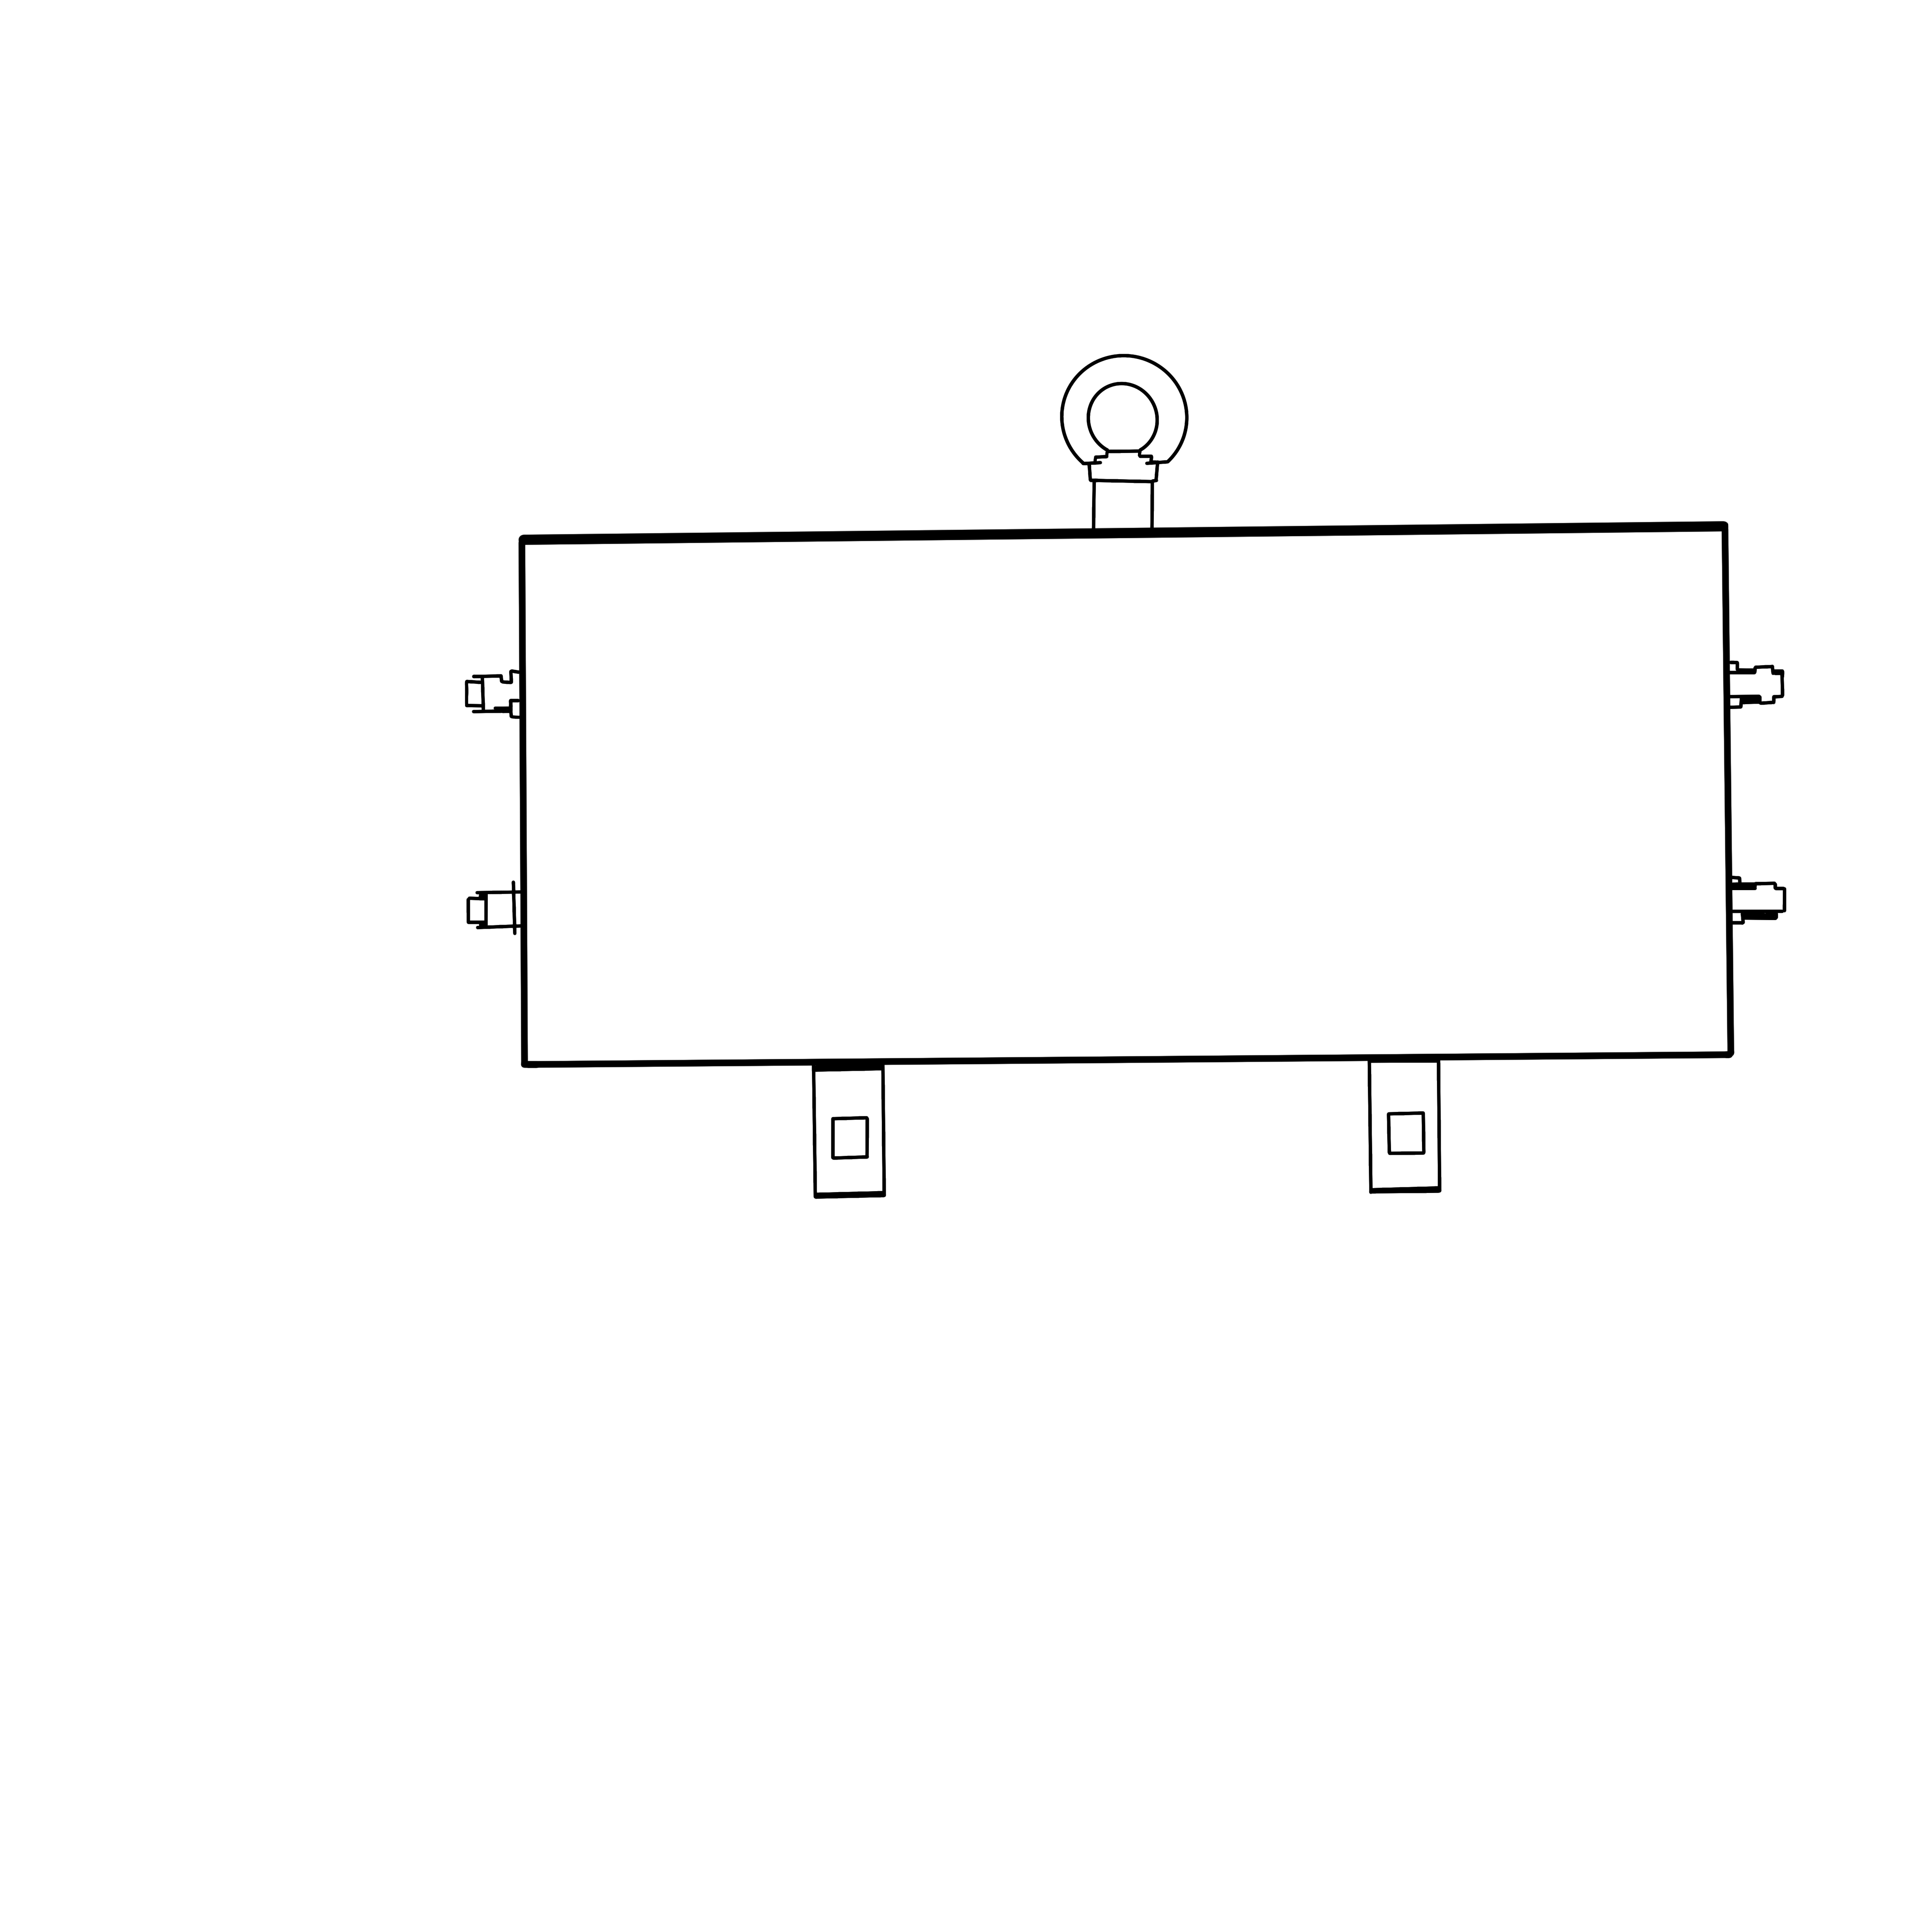

log resized_img.shape and .img.shape (199, 270, 4) (800, 602, 3) 506 704
(214, 234) (4000, 4000, 4)
(214, 234) (234, 214, 4) 214 234


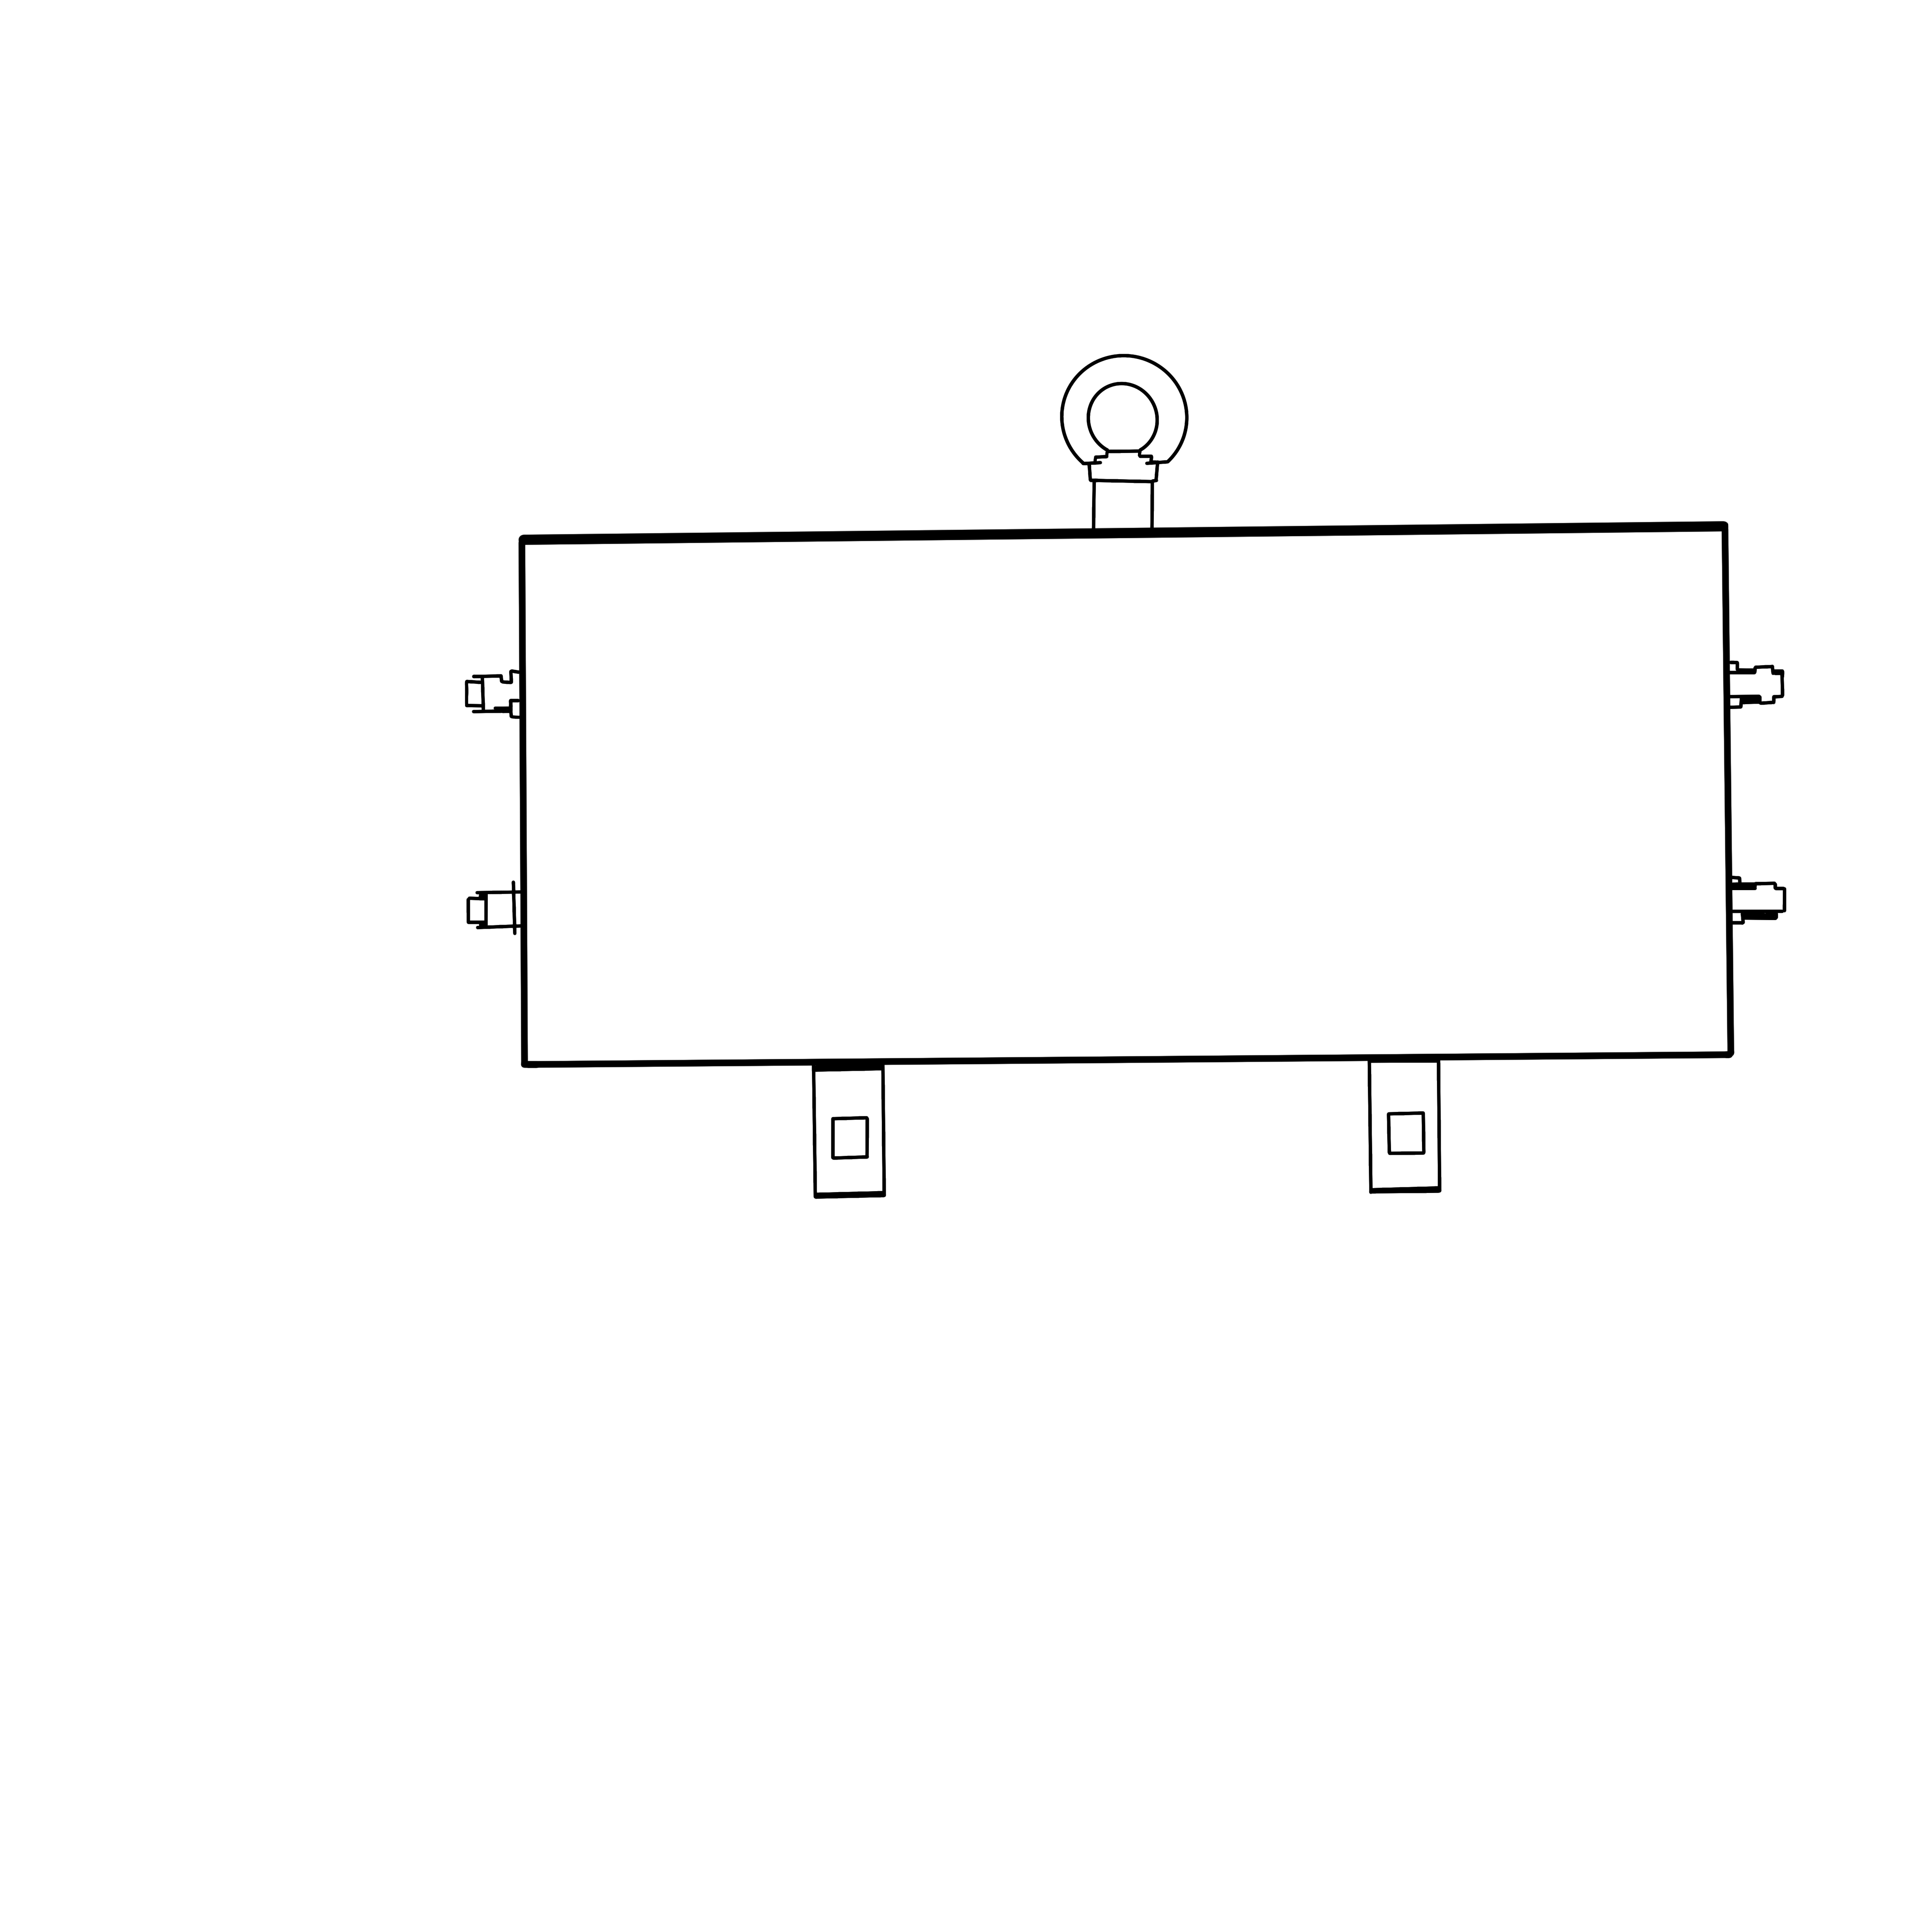

log resized_img.shape and .img.shape (214, 234, 4) (800, 602, 3) 567 473
(202, 245) (4000, 4000, 4)
(202, 245) (245, 202, 4) 202 245


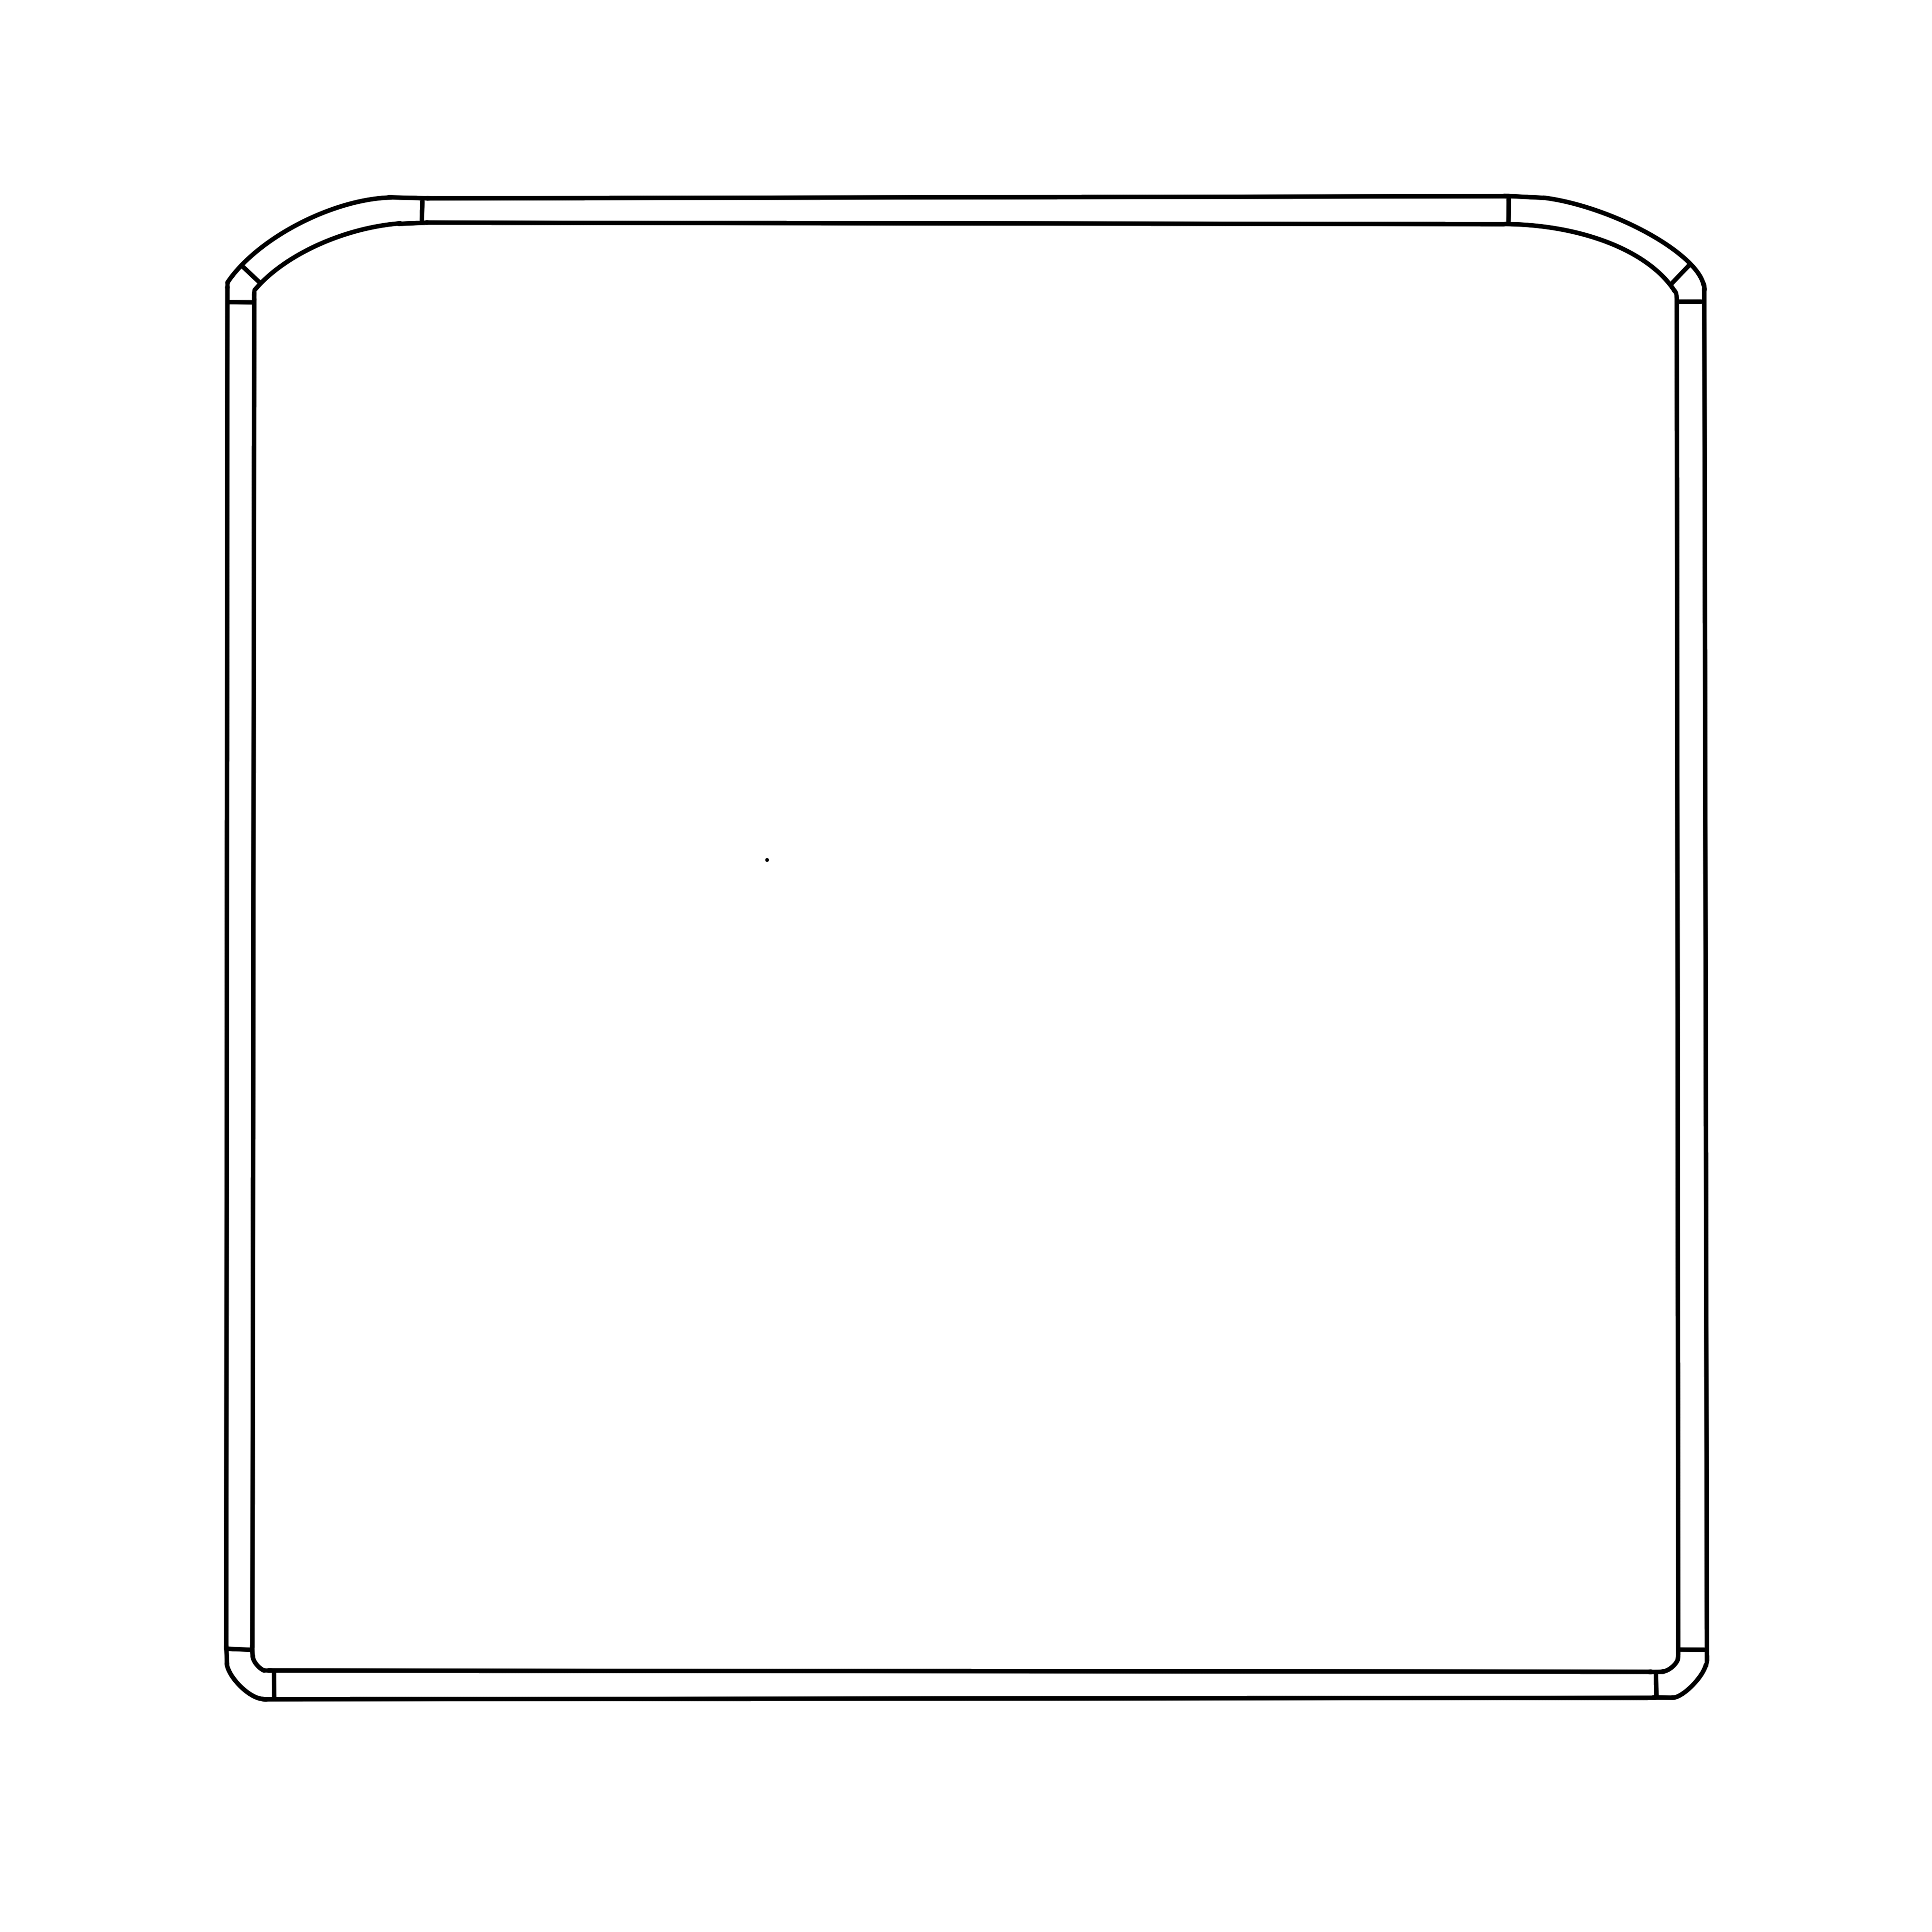

log resized_img.shape and .img.shape (202, 245, 4) (800, 602, 3) 588 255
(250, 200) (4000, 4000, 4)
(250, 200) (200, 250, 4) 250 200


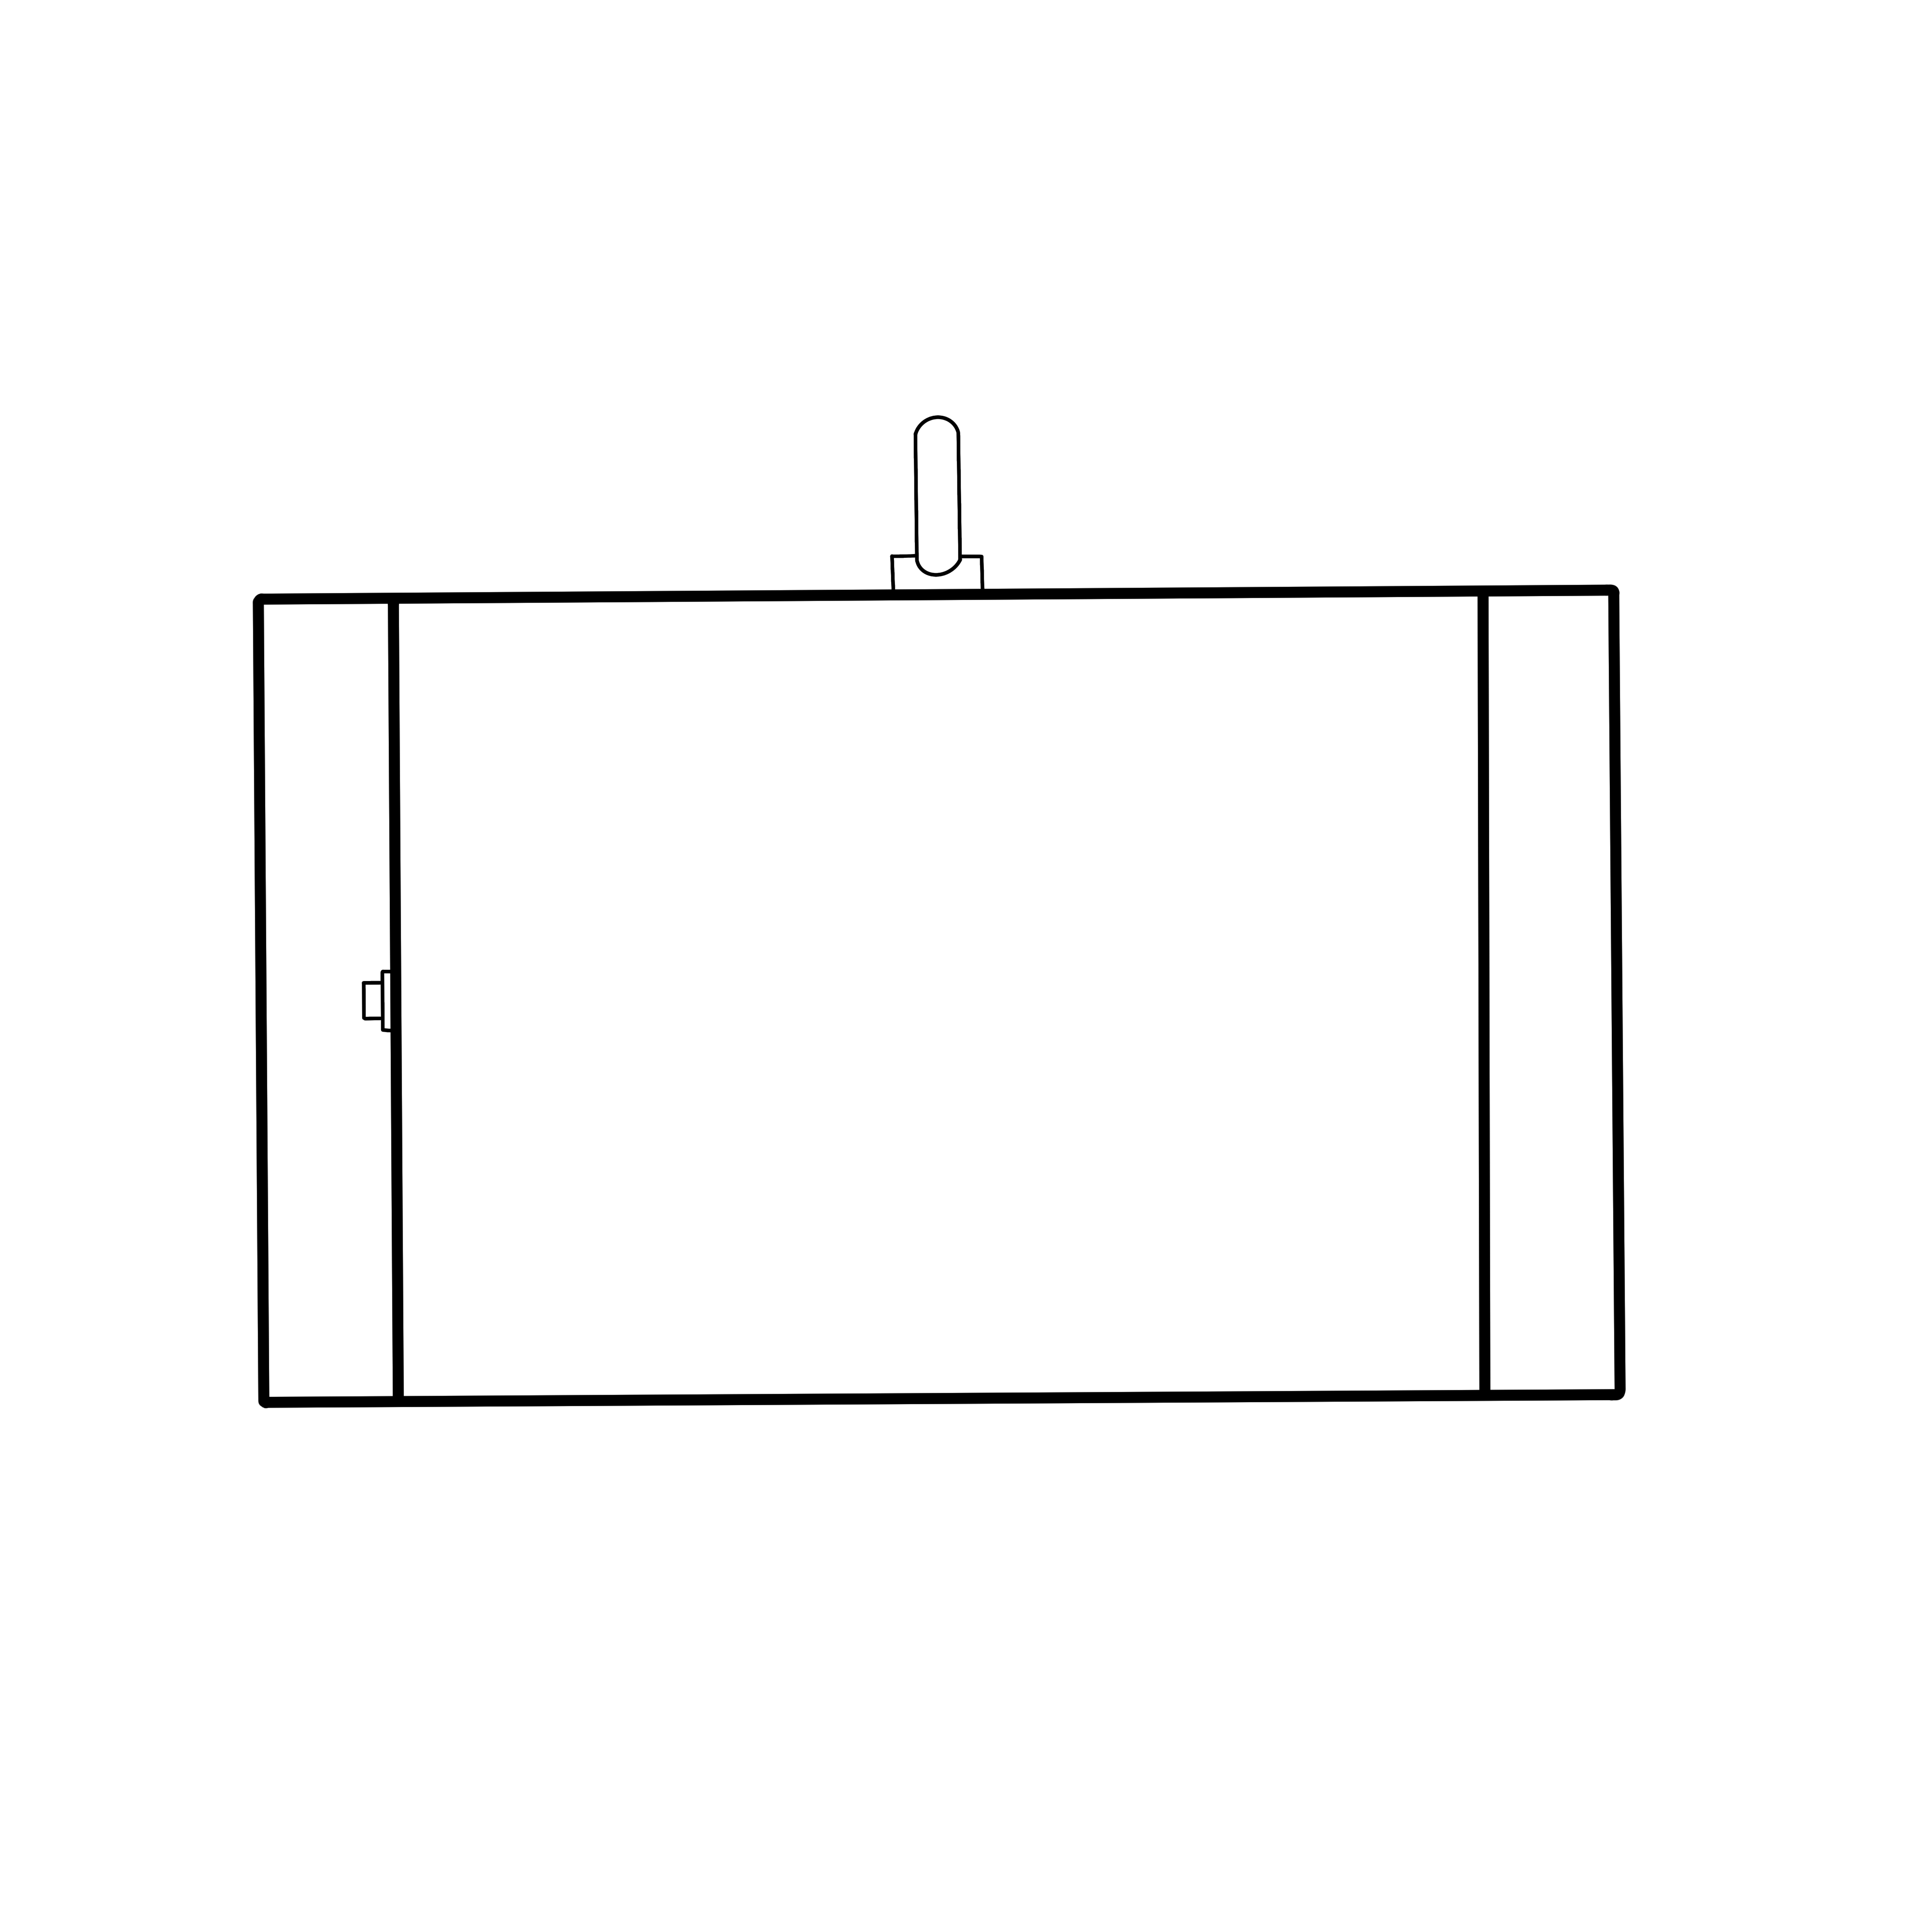

log resized_img.shape and .img.shape (250, 200, 4) (800, 602, 3) 229 679
(41, 153) (43, 59, 4)
(41, 153) (153, 41, 4) 41 153


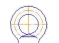

log resized_img.shape and .img.shape (41, 153, 4) (800, 602, 3) 555 216
(112, 43) (93, 51, 4)
(112, 43) (43, 112, 4) 112 43


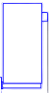

log resized_img.shape and .img.shape (112, 43, 4) (800, 602, 3) 402 200
(60, 142) (36, 70, 4)
(60, 142) (142, 60, 4) 60 142


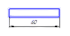

log resized_img.shape and .img.shape (60, 142, 4) (800, 602, 3) 478 692
(90, 57) (148, 152, 4)
(90, 57) (57, 90, 4) 90 57


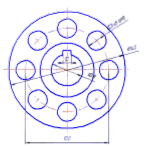

log resized_img.shape and .img.shape (90, 57, 4) (800, 602, 3) 334 651
(46, 110) (43, 59, 4)
(46, 110) (110, 46, 4) 46 110


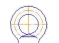

log resized_img.shape and .img.shape (46, 110, 4) (800, 602, 3) 492 571
(35, 140) (93, 51, 4)
(35, 140) (140, 35, 4) 35 140


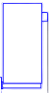

log resized_img.shape and .img.shape (35, 140, 4) (800, 602, 3) 535 380
(106, 46) (93, 51, 4)
(106, 46) (46, 106, 4) 106 46


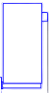

log resized_img.shape and .img.shape (106, 46, 4) (800, 602, 3) 394 380
(38, 130) (26, 24, 4)
(38, 130) (130, 38, 4) 38 130


log resized_img.shape and .img.shape (38, 130, 4) (800, 602, 3) 555 345
(27, 188) (108, 94, 4)
(27, 188) (188, 27, 4) 27 188


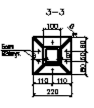

log resized_img.shape and .img.shape (27, 188, 4) (800, 602, 3) 553 243
(45, 116) (93, 51, 4)
(45, 116) (116, 45, 4) 45 116


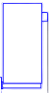

log resized_img.shape and .img.shape (45, 116, 4) (800, 602, 3) 484 625
(41, 151) (43, 59, 4)
(41, 151) (151, 41, 4) 41 151


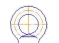

log resized_img.shape and .img.shape (41, 151, 4) (800, 602, 3) 497 454
(30, 171) (43, 59, 4)
(30, 171) (171, 30, 4) 30 171


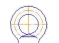

log resized_img.shape and .img.shape (30, 171, 4) (800, 602, 3) 519 410
(37, 131) (26, 24, 4)
(37, 131) (131, 37, 4) 37 131


log resized_img.shape and .img.shape (37, 131, 4) (800, 602, 3) 556 307
(102, 94) (93, 51, 4)
(102, 94) (94, 102, 4) 102 94


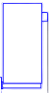

log resized_img.shape and .img.shape (102, 94, 4) (800, 602, 3) 168 666
(102, 48) (148, 152, 4)
(102, 48) (48, 102, 4) 102 48


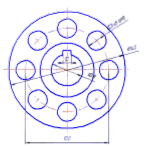

log resized_img.shape and .img.shape (102, 48, 4) (800, 602, 3) 211 556
(97, 50) (36, 70, 4)
(97, 50) (50, 97, 4) 97 50


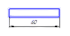

log resized_img.shape and .img.shape (97, 50, 4) (800, 602, 3) 219 664
(71, 69) (64, 65, 4)
(71, 69) (69, 71, 4) 71 69


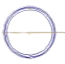

log resized_img.shape and .img.shape (71, 69, 4) (800, 602, 3) 150 549
(84, 59) (36, 70, 4)
(84, 59) (59, 84, 4) 84 59


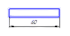

log resized_img.shape and .img.shape (84, 59, 4) (800, 602, 3) 569 168
(46, 106) (64, 65, 4)
(46, 106) (106, 46, 4) 46 106


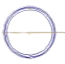

log resized_img.shape and .img.shape (46, 106, 4) (800, 602, 3) 509 163
(147, 34) (43, 59, 4)
(147, 34) (34, 147, 4) 147 34


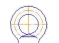

log resized_img.shape and .img.shape (147, 34, 4) (800, 602, 3) 74 662
(54, 90) (28, 20, 4)
(54, 90) (90, 54, 4) 54 90


log resized_img.shape and .img.shape (54, 90, 4) (800, 602, 3) 510 117
Нет полигонов с необходимым мин размером
Удалось построить 21 фигур для 1го изображения
img shape:(982, 694, 3)
поинт по координатам (675, 833)
поинт по координатам (66, 830)
поинт по координатам (74, 22)
поинт по координатам (678, 20)


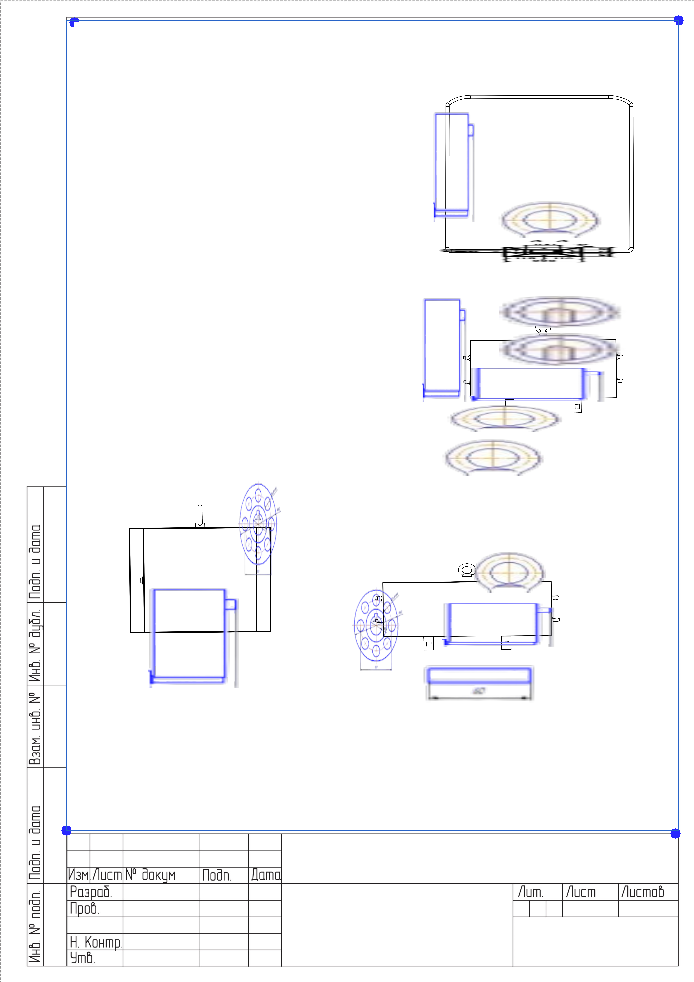

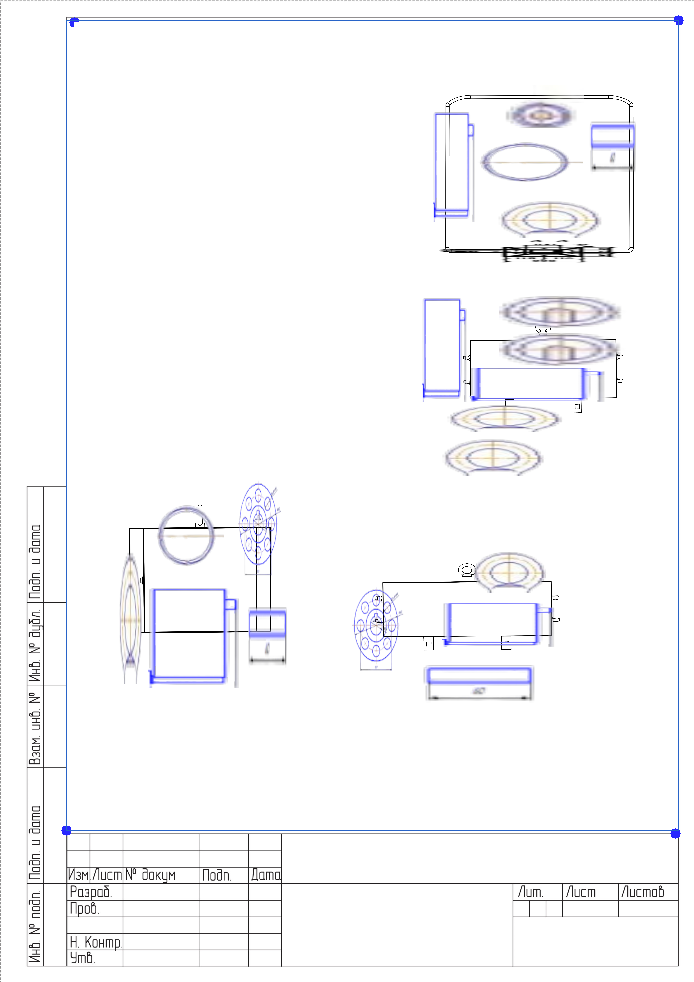

In [184]:
imgs = make_random_images((mf.shape[1],mf.shape[0],3),count=30, percent=0.5, form_count=4)

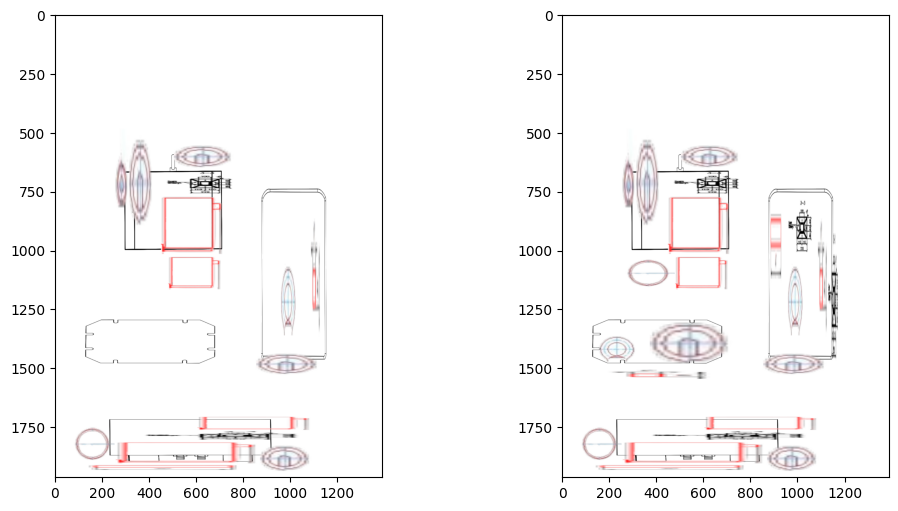

In [85]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

img1, img2 = imgs
axes[0].imshow(img1.astype('uint8'))
axes[1].imshow(img2.astype('uint8'))
fig.set_figwidth(12)  
fig.set_figheight(6)
plt.show()

остатки прошедших времён

(188, 61)
(126, 22)
163.0 36.0
39.0 29.0
52 35
(52, 35)
(999, 746, 3) (35, 52, 3) (126, 22)
er (999, 746, 3) (35, 52, 3) 126 22
(178, 22)
(93, 2)
110.0 4.0
75.0 18.0
83 20
(83, 20)
(999, 746, 3) (20, 83, 3) (93, 2)
er (999, 746, 3) (20, 83, 3) 93 2
(126, 39)
(75, 6)
87.0 9.0
46.0 32.0
48 32
(48, 32)
(999, 746, 3) (32, 48, 3) (75, 28)
er (999, 746, 3) (32, 48, 3) 75 28
(328, 127)
(55, 21)
316.0 121.0
15.0 6.0
273 21
(273, 21)
(999, 746, 3) (21, 273, 3) (55, 460)
er (999, 746, 3) (21, 273, 3) 55 460
(597, 95)
(115, 63)
581.0 91.0
47.0 8.0
210 29
(210, 29)
(999, 746, 3) (29, 210, 3) (517, 714)
er (999, 746, 3) (29, 210, 3) 517 714
(325, 63)
(122, 36)
301.0 55.0
56.0 19.0
82 19
(82, 19)
(999, 746, 3) (19, 82, 3) (524, 687)
er (999, 746, 3) (19, 82, 3) 524 687
(273, 85)
(50, 2)
255.0 78.0
18.0 35.0
43 80
(43, 80)
(999, 746, 3) (80, 43, 3) (105, 483)
er (999, 746, 3) (80, 43, 3) 105 483
(55, 106)
(24, 21)
40.0 57.0
18.0 56.0
27 69
(27, 69)
(999, 746, 3) (69, 27, 3) (24, 481)
er (999, 746, 3)

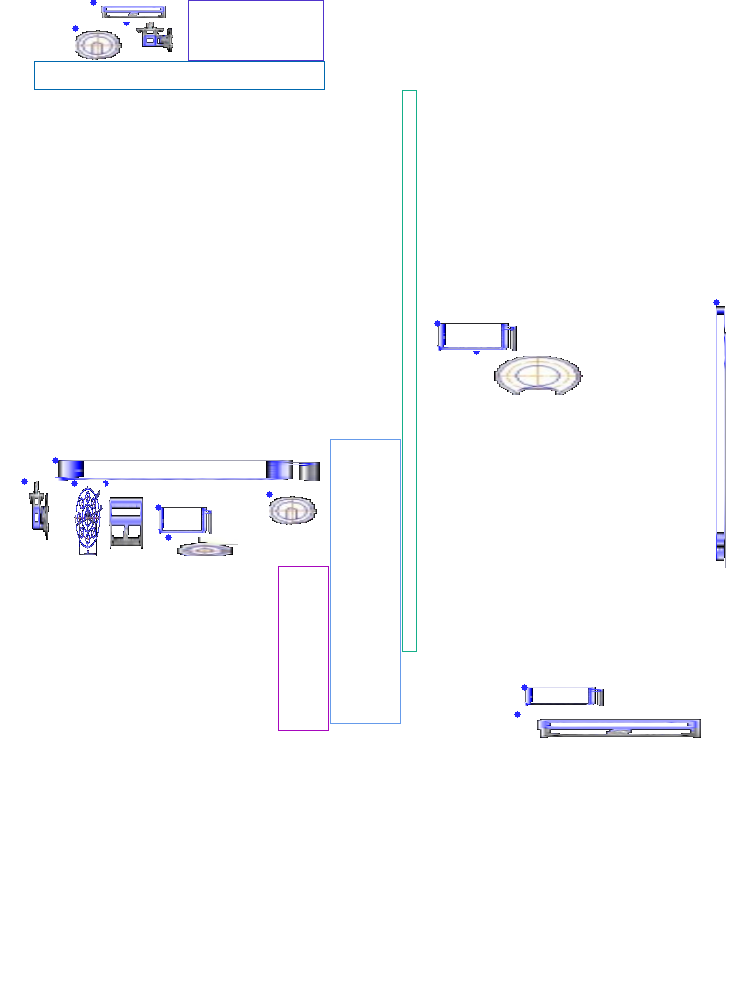

In [ ]:
p = make_image((mf.shape[0], mf.shape[1], 3), "r:5 cmpnt:15")

In [ ]:
p.shape

(999, 746, 3)

In [ ]:
img1.shape

(1122, 794, 3)

In [ ]:
mf.corners[0].x, mf.corners[0].y

(240, 64)

In [ ]:
mf.shape

(6243, 4661)

er (1122, 794, 3) (999, 746, 3) 9 38


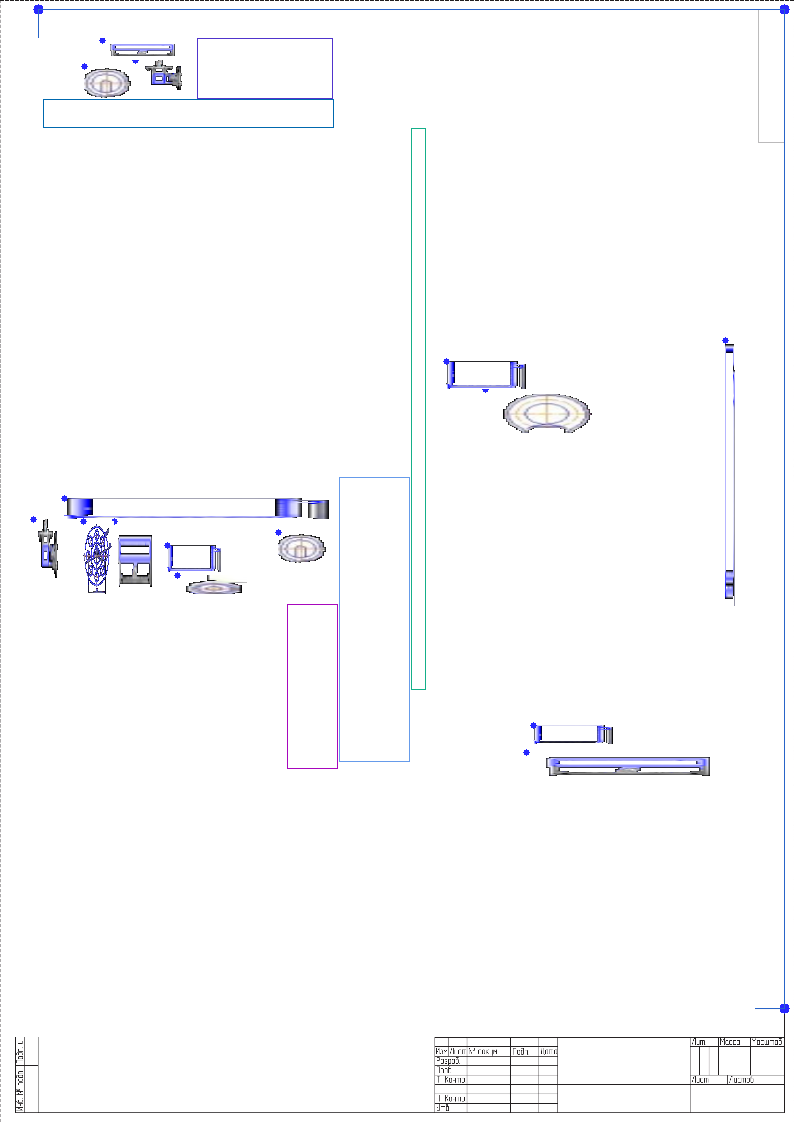

In [ ]:
cv2_imshow(overlay(img1, p, mf.corners[0].y, mf.corners[0].x))

er (1122, 794, 3) (999, 746, 3) 9 38


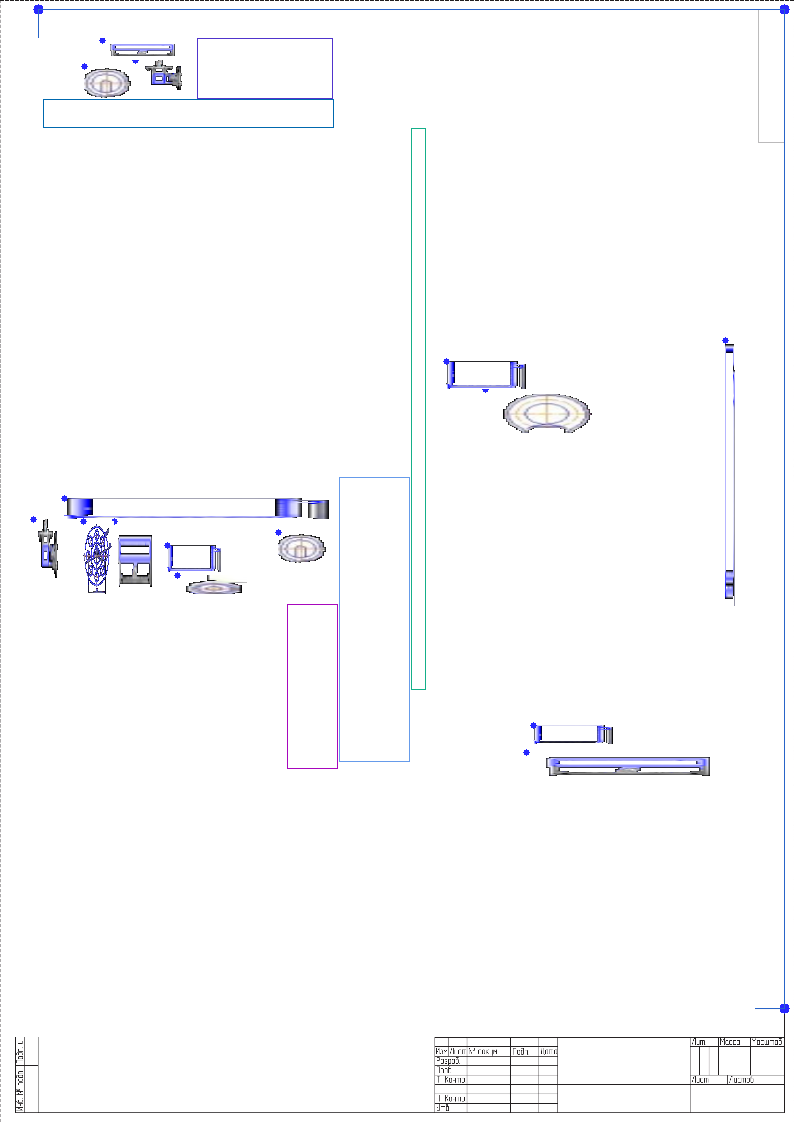

In [ ]:
cv2_imshow(overlay(img1, p, mf.corners[0].y, mf.corners[0].x))

In [ ]:
a = np.empty((4, 3, 2))
a.fill(255)
a

array([[[255., 255.],
        [255., 255.],
        [255., 255.]],

       [[255., 255.],
        [255., 255.],
        [255., 255.]],

       [[255., 255.],
        [255., 255.],
        [255., 255.]],

       [[255., 255.],
        [255., 255.],
        [255., 255.]]])

In [ ]:
img1.shape

(7017, 4963, 3)

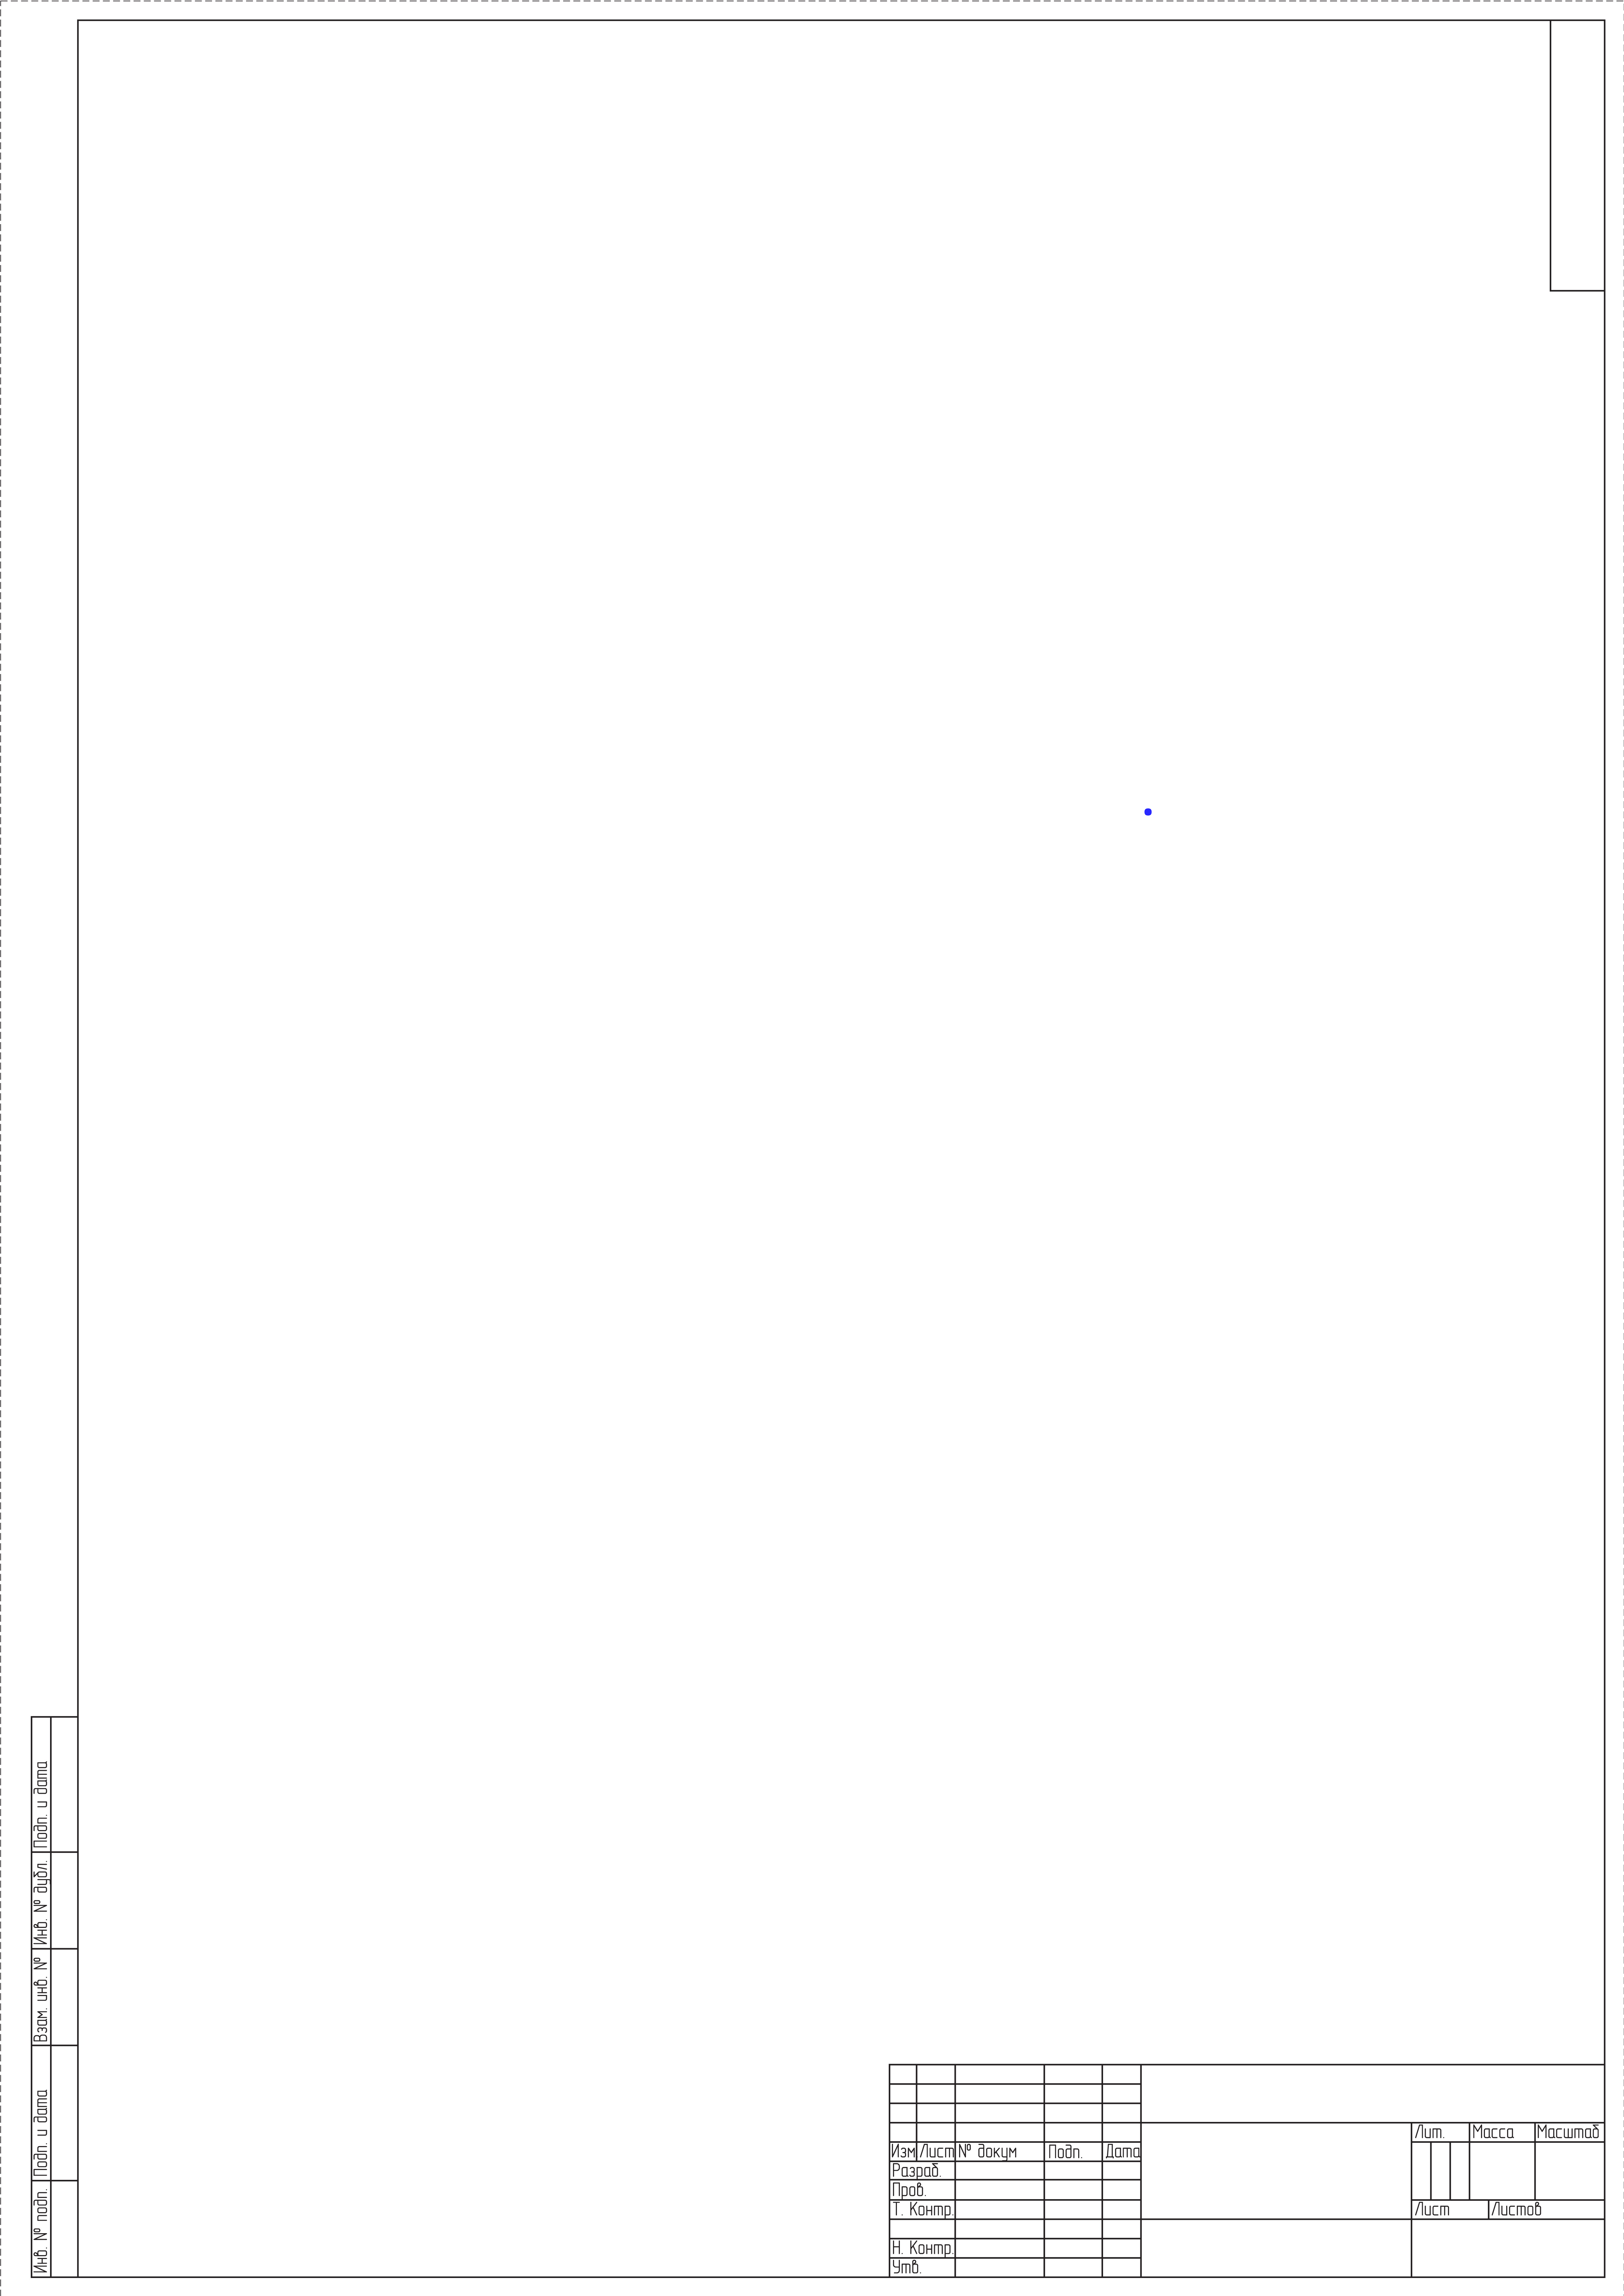

In [ ]:
cv2_imshow(img1)

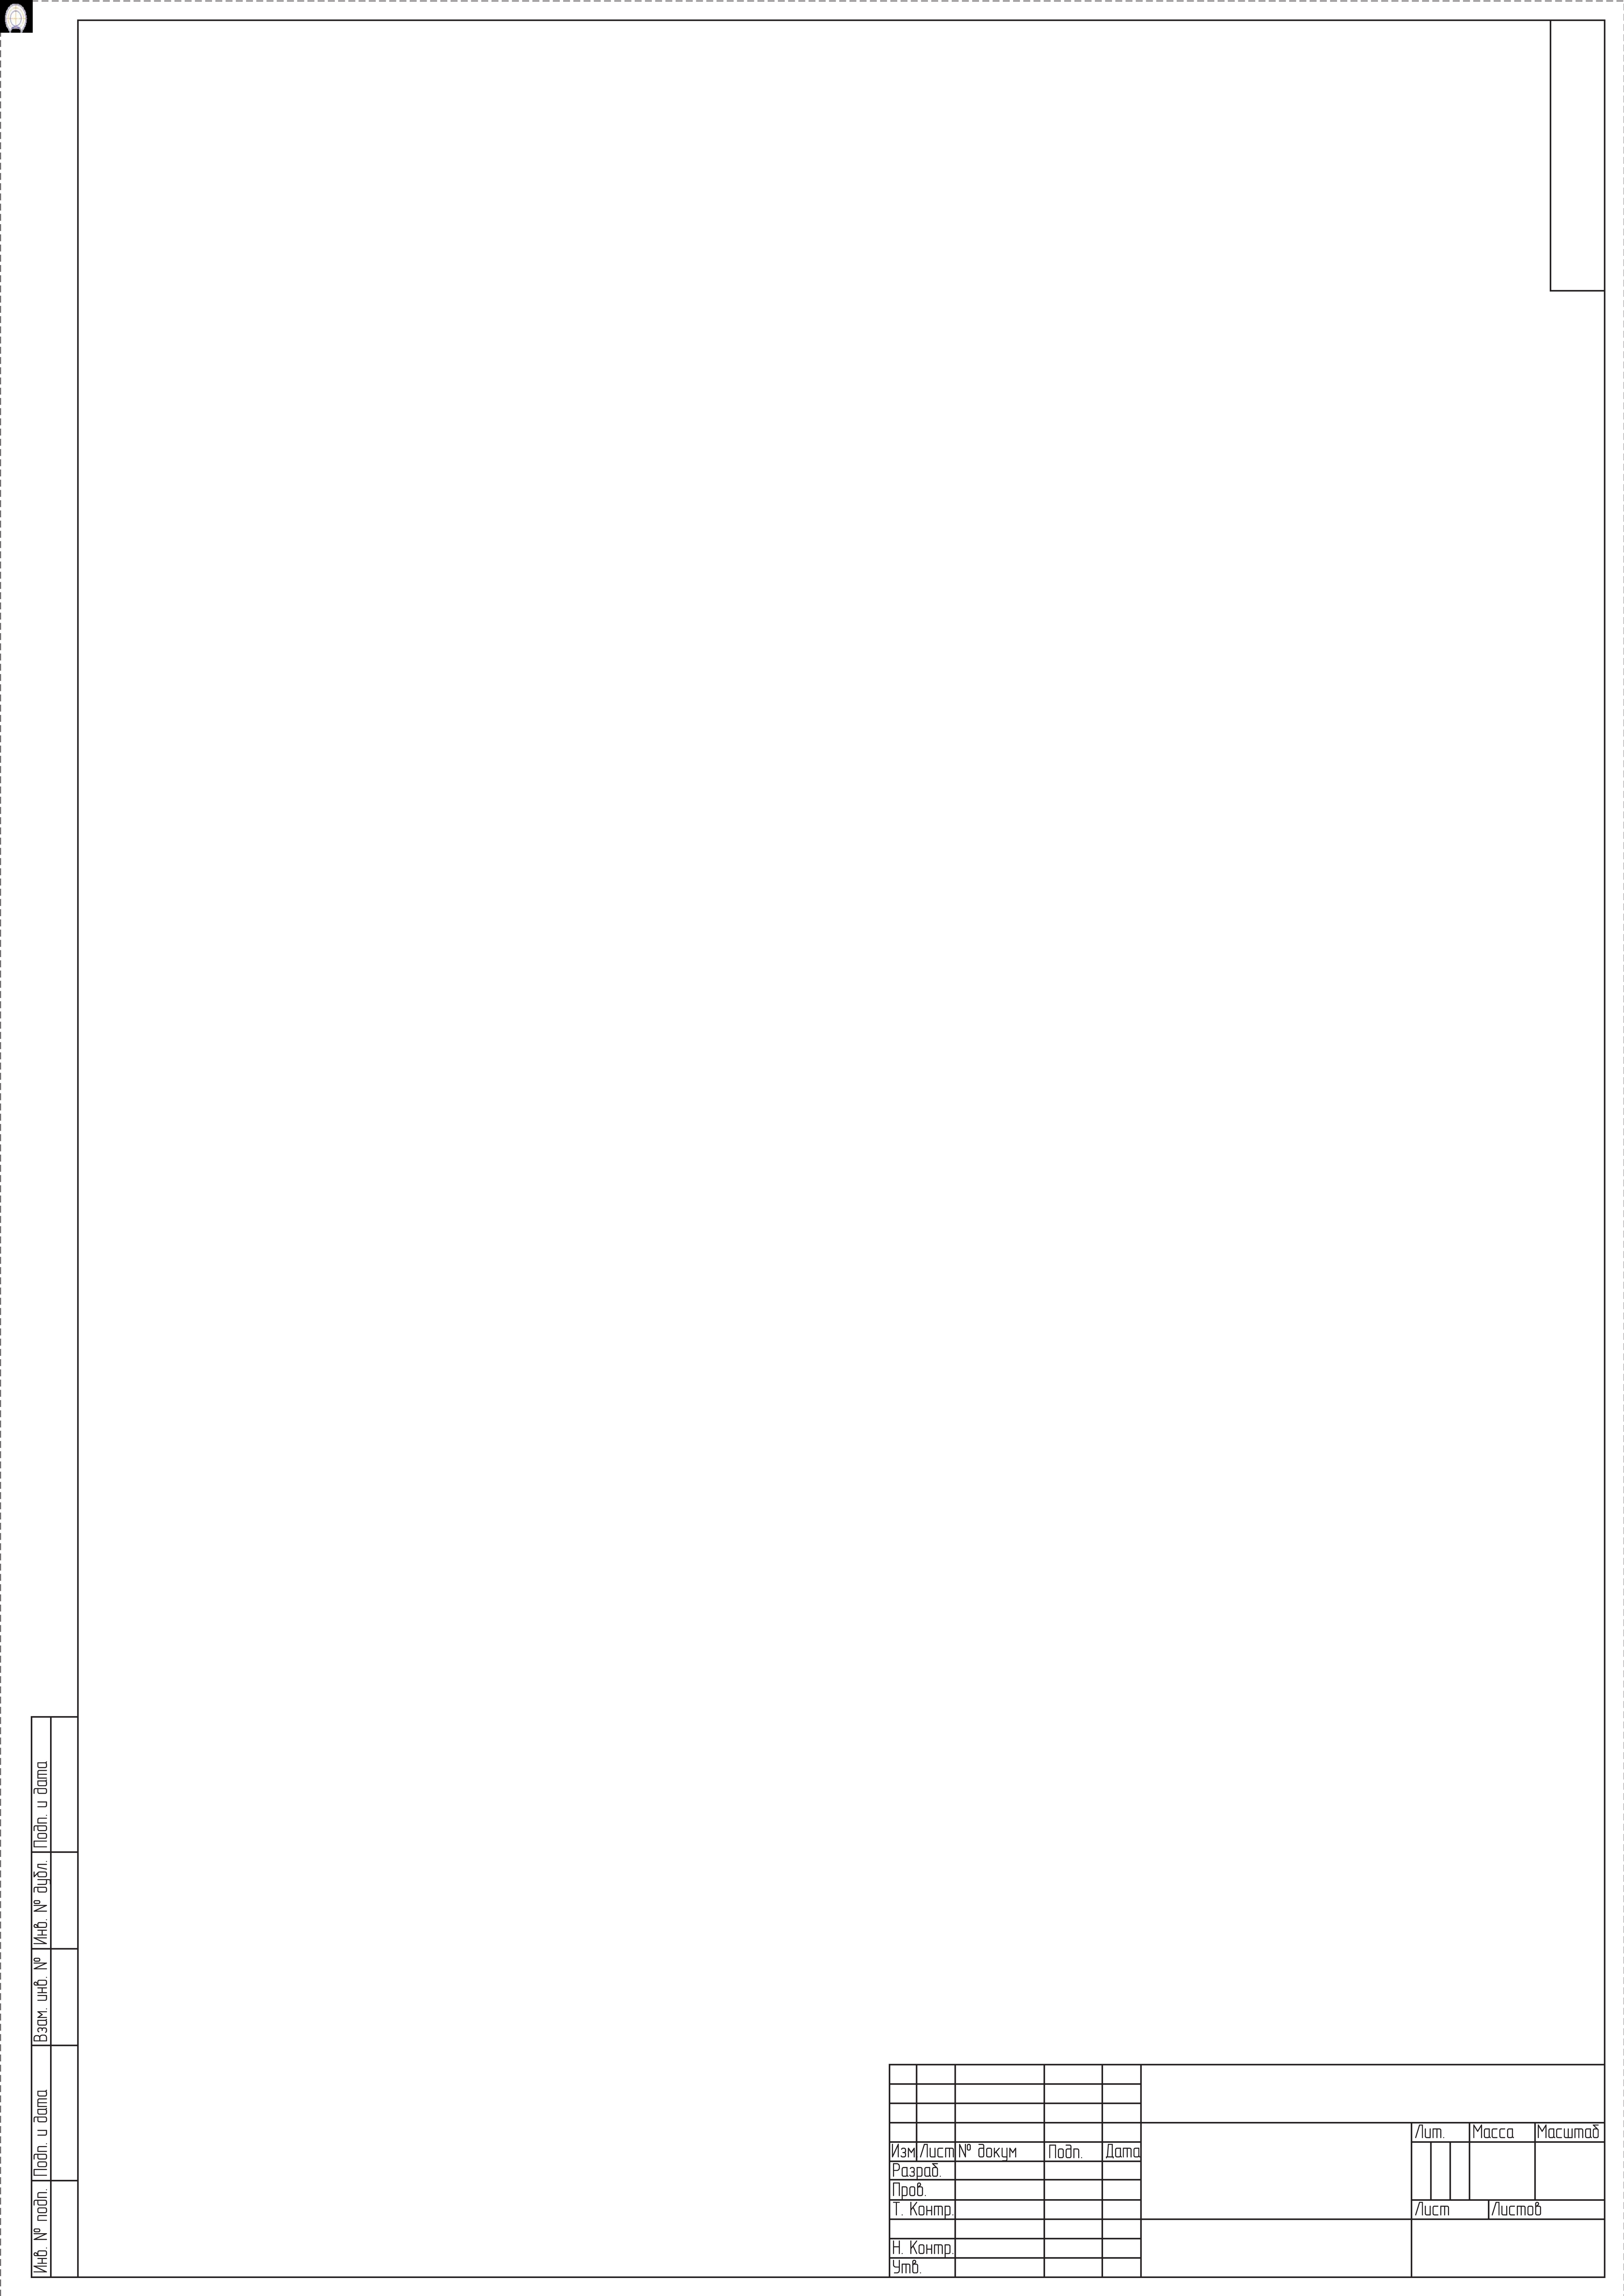

In [ ]:
dst = img1.copy()
h,w,ch = img2.shape
for i in range(h):
  for j in range(w):
    dst[i,j,:]= img2[i,j,:] if img2[i,j][0]!=0 else [255,255,255]

cv2_imshow(dst)